In [ ]:
"""
Copyright (2023) Bytedance Ltd. and/or its affiliates

Licensed under the Apache License, Version 2.0 (the "License"); 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License. 
"""

In [1]:
# import everything
import torch
from PIL import Image
import torchvision.transforms as T
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from utils import prepare_sam, prepare_osm, prepare_instruction, prepare_image, get_masks, get_context_mask, get_classes

In [2]:
# prepare model
_, sam_predictor = prepare_sam(sam_checkpoint="./sam_vit_h_4b8939.pth")

In [3]:
class_generator, processor = prepare_osm(osm_checkpoint="./osm_final.pt")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
lang_x, qformer_lang_x = prepare_instruction(processor, "What is in the segmentation mask? Assistant:")
input_size = processor.image_processor.size["height"]

In [5]:
@torch.no_grad()
def get_masks_with_point(image, predictor, input_point, input_label, input_size):
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    # masks: (3, H, W)
    masks = [masks[0], masks[1], masks[2]]
    def process_mask(m):
        m = Image.fromarray(m)
        if min(m.size) == max(m.size):
            m = T.functional.resize(m, size=input_size, interpolation=T.functional.InterpolationMode.NEAREST)
        else:
            m = T.functional.resize(m, size=input_size-1,
                                    max_size=input_size, interpolation=T.functional.InterpolationMode.NEAREST)
        m = np.array(m)
        return m

    masks = [process_mask(m) for m in masks] # each one is a H x W binary mask  
    print(f"Obtained {len(masks)} masks from SAM with input_point {input_point} and input_label {input_label}")
    return masks

@torch.no_grad()
def read_process_and_vis(image_path, input_size, mask_generator, class_generator, processor, qformer_lang_x, lang_x, vis_alpha, input_point, input_label):
    image_for_osm, image_for_seg = prepare_image(image_path, input_size)
    seg_masks = get_masks_with_point(image_for_seg, mask_generator, input_point, input_label, input_size)
    if len(seg_masks) == 0:
        return

    classes, class_probs = get_classes(image_for_osm, seg_masks, class_generator, processor, qformer_lang_x, lang_x)

    # draw vis
    image_with_point = image_for_seg[:, :, ::-1].copy()
    image_with_point = cv2.drawMarker(img=image_with_point,
                                    position=(input_point[0][0],input_point[0][1]),
                                    color=(255, 0, 0),
                                    markerType=cv2.MARKER_STAR,
                                    markerSize=40,
                                    thickness=2) # BGR
    image_with_point = image_with_point[:, :, ::-1] # to RGB
    
    plt.figure(figsize=(10,10))
    plt.imshow(image_with_point)
    plt.title(f"Point: {input_point}", fontsize=18)
    plt.axis('off')
    plt.show()
    for i in range(len(seg_masks)):
        image = image_with_point.copy()
        image = image.astype(np.float32)
        color = np.array([220, 20, 60])
        cur_mask = seg_masks[i]
        cur_mask = cur_mask.astype(np.float32)[:, :, None]
        image = image * (1.0 - cur_mask) + image * cur_mask * (1.0 - vis_alpha) + color * cur_mask * vis_alpha
        image = image.astype(np.uint8)
        image = image.astype(np.uint8) # BGR -> RGB
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        plt.title(f"Mask {i}: {classes[i]} ({class_probs[i]})", fontsize=18)
        plt.axis('off')
        plt.show()
    return

Obtained 3 masks from SAM with input_point [[512 512]] and input_label [1]
predcited class names: ['tail', 'dog', 'dog']
predcited class probs: [0.6183205246925354, 0.9935053586959839, 0.9979039430618286]


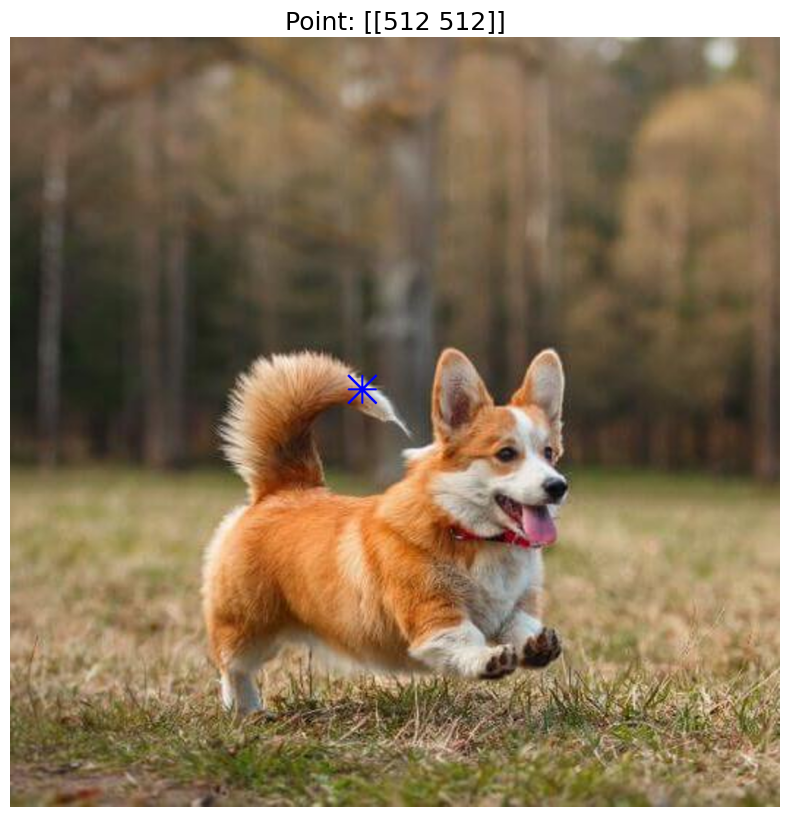

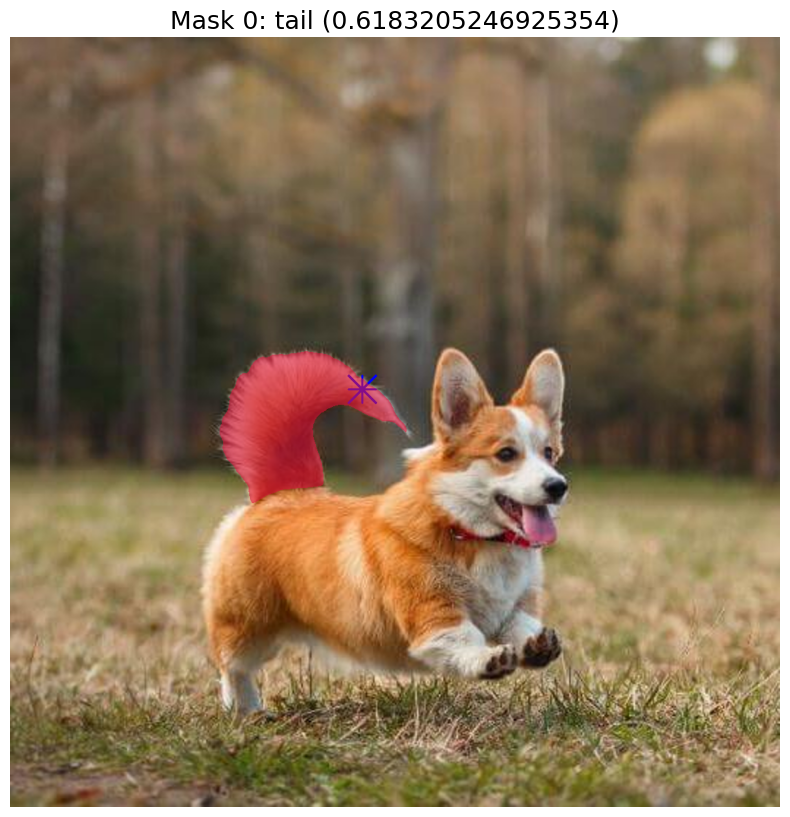

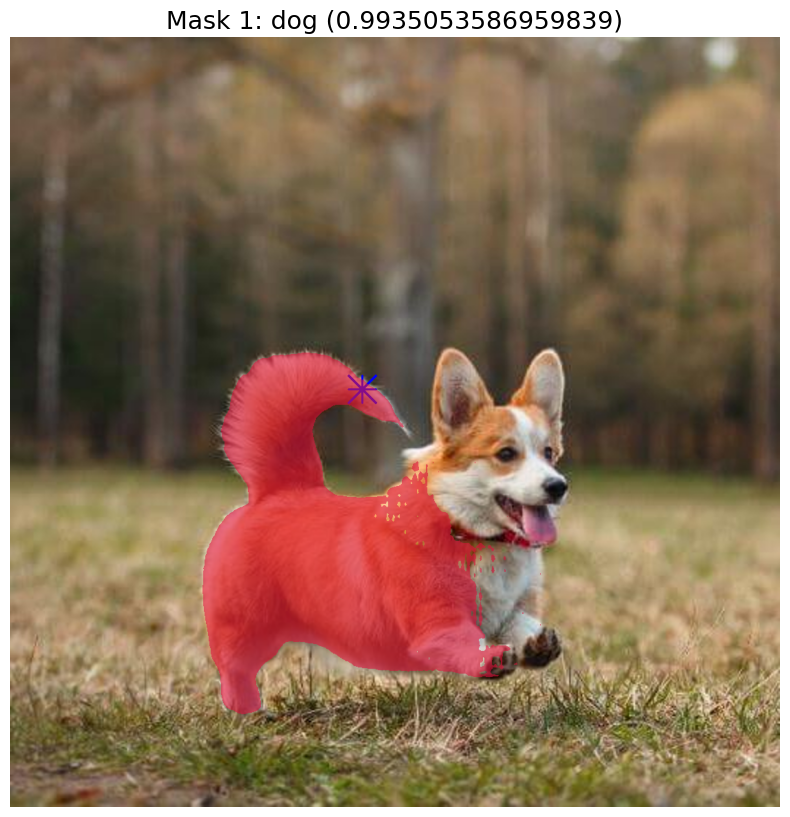

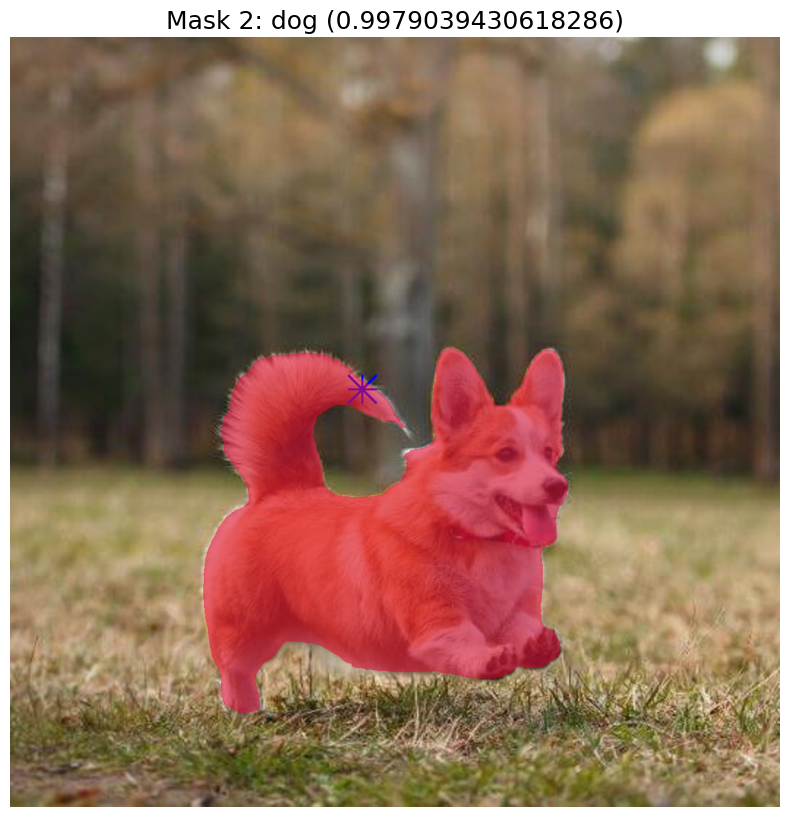

In [6]:
image_path = "./imgs/demo.jpg"
read_process_and_vis(image_path, input_size=1120, mask_generator=sam_predictor, class_generator=class_generator, processor=processor, qformer_lang_x=qformer_lang_x, lang_x=lang_x, vis_alpha=.6,
                    input_point=np.array([[512, 512]]), input_label=np.array([1]))

Obtained 3 masks from SAM with input_point [[640 512]] and input_label [1]
predcited class names: ['ear', 'ear', 'dog']
predcited class probs: [0.8316867351531982, 0.5370179414749146, 0.9978712797164917]


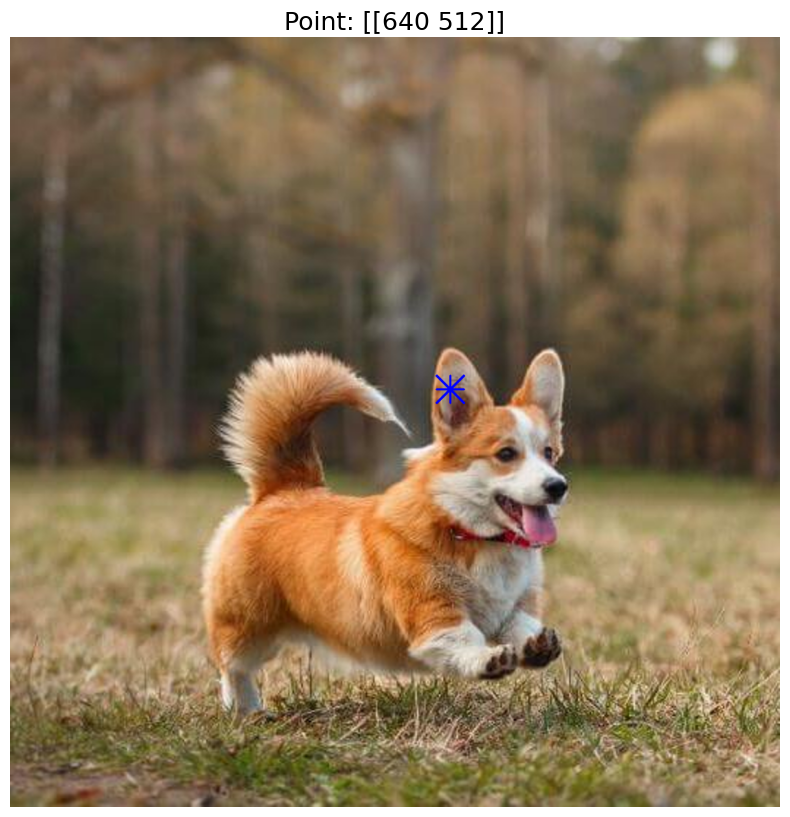

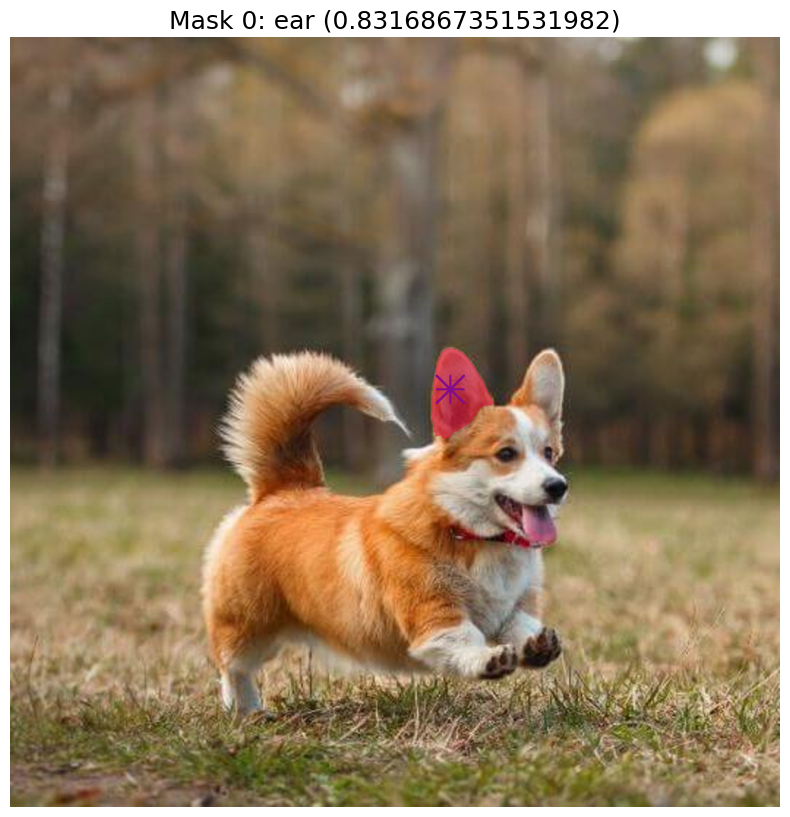

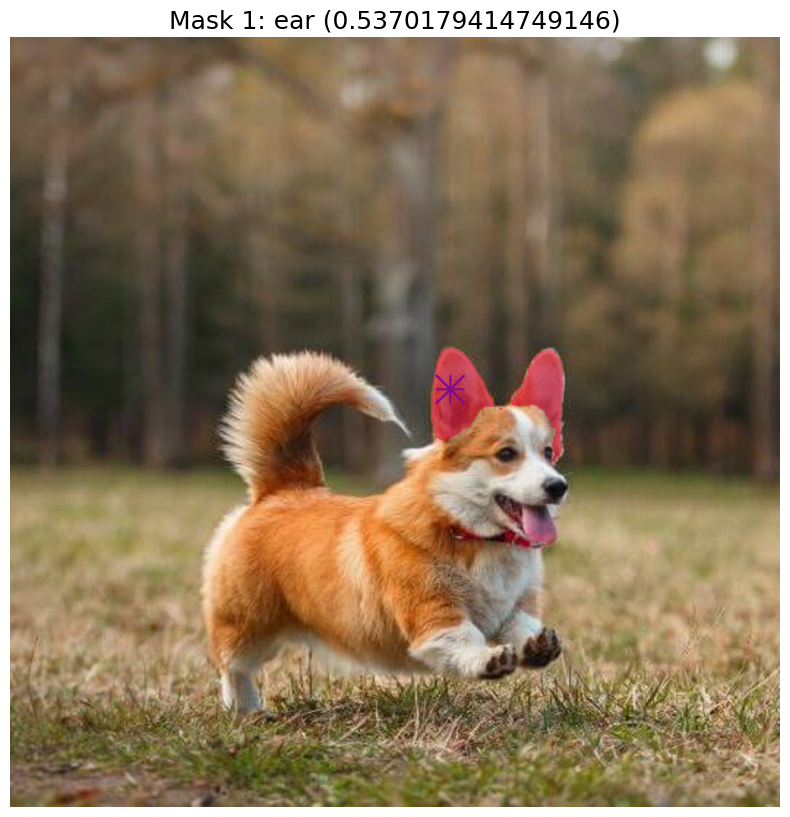

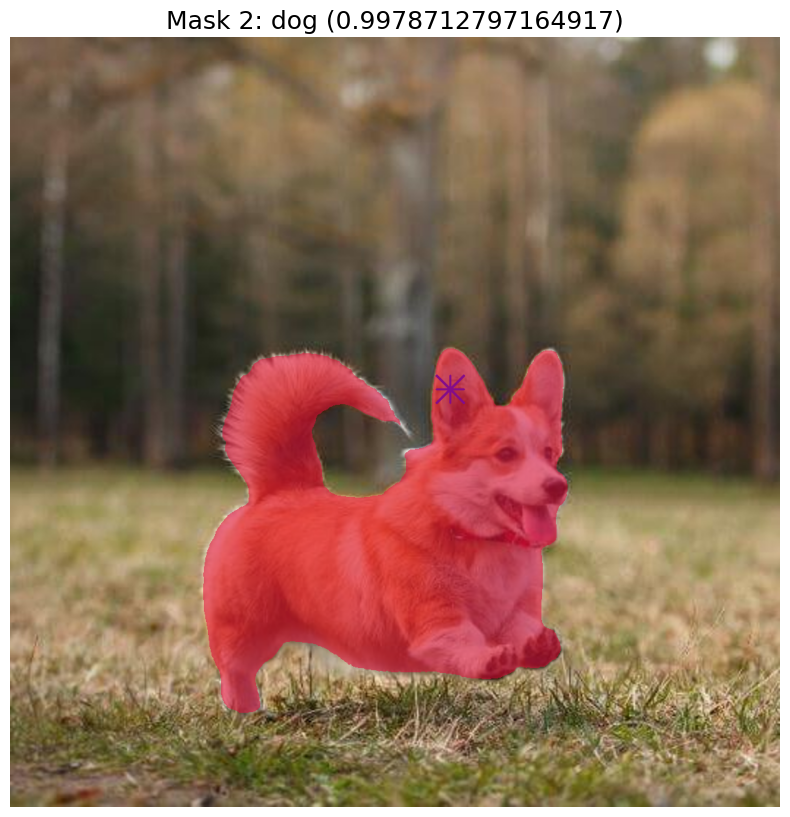

In [7]:
read_process_and_vis(image_path, input_size=1120, mask_generator=sam_predictor, class_generator=class_generator, processor=processor, qformer_lang_x=qformer_lang_x, lang_x=lang_x, vis_alpha=.6,
                    input_point=np.array([[640, 512]]), input_label=np.array([1]))